**Introduction**
This is a regression task with the goal of making predictions as close as possible to the true values. My idea is as follows: first, read the dataset, clean and preprocess it. The purpose of this step is to remove rows in the dataset that contain unknown and missing values, and to convert non-numerical data into numerical values, making it easier for the model to perform calculations. Given the small number of missing and unknown values in the dataset, in order to avoid affecting the accuracy of the model, we adopted the method of removing values instead of using the average value for completion or other methods of completion. Next, we will analyze the variables in the dataset. We plan to use correlation analysis, scatter plot matrix, and the method of calculating important variables using random forests to find more important variables. After sorting the importance of variables, we will attempt to construct models with different numbers of variables and analyze them. We will divide the dataset into training and testing sets and perform N-fold cross validation on the training set to see the effectiveness of the model. Finally, we will summarize.

In [136]:
#Use Pandas to read the dataset and check the first few pieces of data in the dataset
import pandas as pd
import numpy as np
column_names = ["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style","drive-wheels",
                "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type", "num-cylinders", "engine-size",
                "fuel-system", "bore","stroke", "compression-ratio", "horse-power", "peak-rpm", "city-mpg","highway-mpg", "price"]
usecols = ['height', 'width', 'length', 'wheel-base','engine-size', 'horse-power', 'peak-rpm', 'city-mpg','curb-weight']

df = pd.read_csv('https://raw.githubusercontent.com/Keming-Cui/DAV_6150_Data_Science/main/M2_Data.csv', sep = ",", names = column_names , usecols=usecols)
df.head(10)

,wheel-base,length,width,height,curb-weight,engine-size,horse-power,peak-rpm,city-mpg
0,88.6,168.8,64.1,48.8,2548,130,111,5000,21
1,88.6,168.8,64.1,48.8,2548,130,111,5000,21
2,94.5,171.2,65.5,52.4,2823,152,154,5000,19
3,99.8,176.6,66.2,54.3,2337,109,102,5500,24
4,99.4,176.6,66.4,54.3,2824,136,115,5500,18
5,99.8,177.3,66.3,53.1,2507,136,110,5500,19
6,105.8,192.7,71.4,55.7,2844,136,110,5500,19
7,105.8,192.7,71.4,55.7,2954,136,110,5500,19
8,105.8,192.7,71.4,55.9,3086,131,140,5500,17
9,99.5,178.2,67.9,52.0,3053,131,160,5500,16


In [137]:
#Check the size of the dataset
len(df)

205

In [138]:
#Check for missing values in all columns
df.isnull().sum()

wheel-base     0
length         0
width          0
height         0
curb-weight    0
engine-size    0
horse-power    0
peak-rpm       0
city-mpg       0
dtype: int64

In [139]:
#There are no missing values in the dataset, but there are some column values that are '?', So we need to handle it
df.replace('?', np.nan, inplace=True)  # Replace the question mark character with NaN
df.isnull().sum()#Check for missing values in all columns

wheel-base     0
length         0
width          0
height         0
curb-weight    0
engine-size    0
horse-power    2
peak-rpm       2
city-mpg       0
dtype: int64

In [140]:
#Due to the relatively small number of rows containing question marks, we will directly remove these rows
df.dropna(inplace=True)#Remove missing values
len(df)#Recheck the size of the dataset

203

In [141]:
#There may be duplicate data in the dataset, so we use drop_duplicates function removes duplicate rows from the dataset
df.drop_duplicates(inplace=True)#Remove duplicate rows
len(df)#Recheck the size of the dataset

189

In [142]:
df.dtypes#Check the type of data in each column

wheel-base     float64
length         float64
width          float64
height         float64
curb-weight      int64
engine-size      int64
horse-power     object
peak-rpm        object
city-mpg         int64
dtype: object

In [143]:
#It can be observed that some columns have non-numerical data types. As the regression model can only belong to numerical data types, we will force some types of data to be converted to numerical types
df['peak-rpm'] = df['peak-rpm'].astype(int)
df['horse-power'] = df['horse-power'].astype(int)
df.dtypes#Recheck the type of data in each column

wheel-base     float64
length         float64
width          float64
height         float64
curb-weight      int64
engine-size      int64
horse-power      int32
peak-rpm         int32
city-mpg         int64
dtype: object

Below, we will conduct a correlation analysis on all attributes to see which variables have a significant correlation with the response variables

In [145]:
# Calling the corr function can obtain the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,wheel-base,length,width,height,curb-weight,engine-size,horse-power,peak-rpm,city-mpg
wheel-base,1.000000,0.882456,0.798502,0.585351,0.780755,0.574991,0.373132,-0.337591,-0.497571
length,0.882456,1.000000,0.836446,0.492957,0.877499,0.680208,0.563951,-0.261041,-0.682068
width,0.798502,0.836446,1.000000,0.272972,0.869293,0.741531,0.659222,-0.190906,-0.657413
height,0.585351,0.492957,0.272972,1.000000,0.296632,0.054088,-0.110120,-0.295801,-0.066134
curb-weight,0.780755,0.877499,0.869293,0.296632,1.000000,0.846981,0.758736,-0.244470,-0.769989
engine-size,0.574991,0.680208,0.741531,0.054088,0.846981,1.000000,0.812471,-0.230732,-0.663705
horse-power,0.373132,0.563951,0.659222,-0.110120,0.758736,0.812471,1.000000,0.130716,-0.806392
peak-rpm,-0.337591,-0.261041,-0.190906,-0.295801,-0.244470,-0.230732,0.130716,1.000000,-0.110000
city-mpg,-0.497571,-0.682068,-0.657413,-0.066134,-0.769989,-0.663705,-0.806392,-0.110000,1.000000


In [146]:
#Based on correlation analysis, we believe that height and peak rpm may be less important attributes (for curb weight)
#We divide the eight attributes into three classes: first class length width engine size (correlation above 0.8), second class wheel base horse power city mpg (correlation above 0.7), and third class height peak rpm (correlation above 0.2)

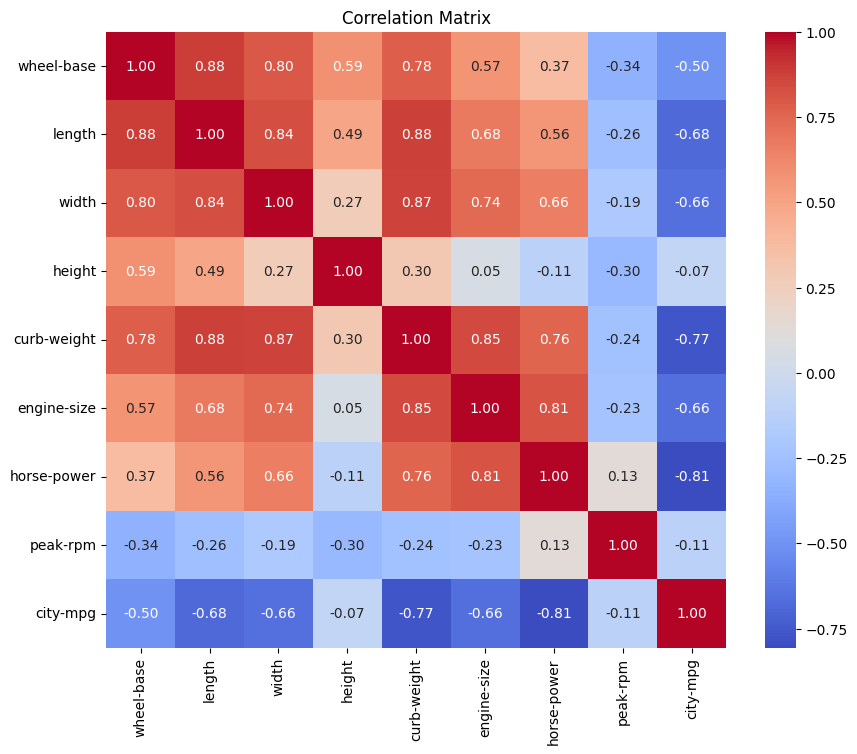

In [147]:
#We can use the PLT function to draw a heatmap of the correlation matrix, from which we can more intuitively see the correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt
# 绘制相关系数矩阵的热图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

From the graph, we can see that length width engine size is more important (correlation higher than 0.8), followed by wheel base horse power city mpg (correlation higher than 0.7), and height peak rpm (correlation higher than 0.2)

Below, we will draw scatter plots for each variable and vector variable on the X and Y axes, respectively. Through the scatter plots, we can see which variables and response variables tend to have a more linear relationship

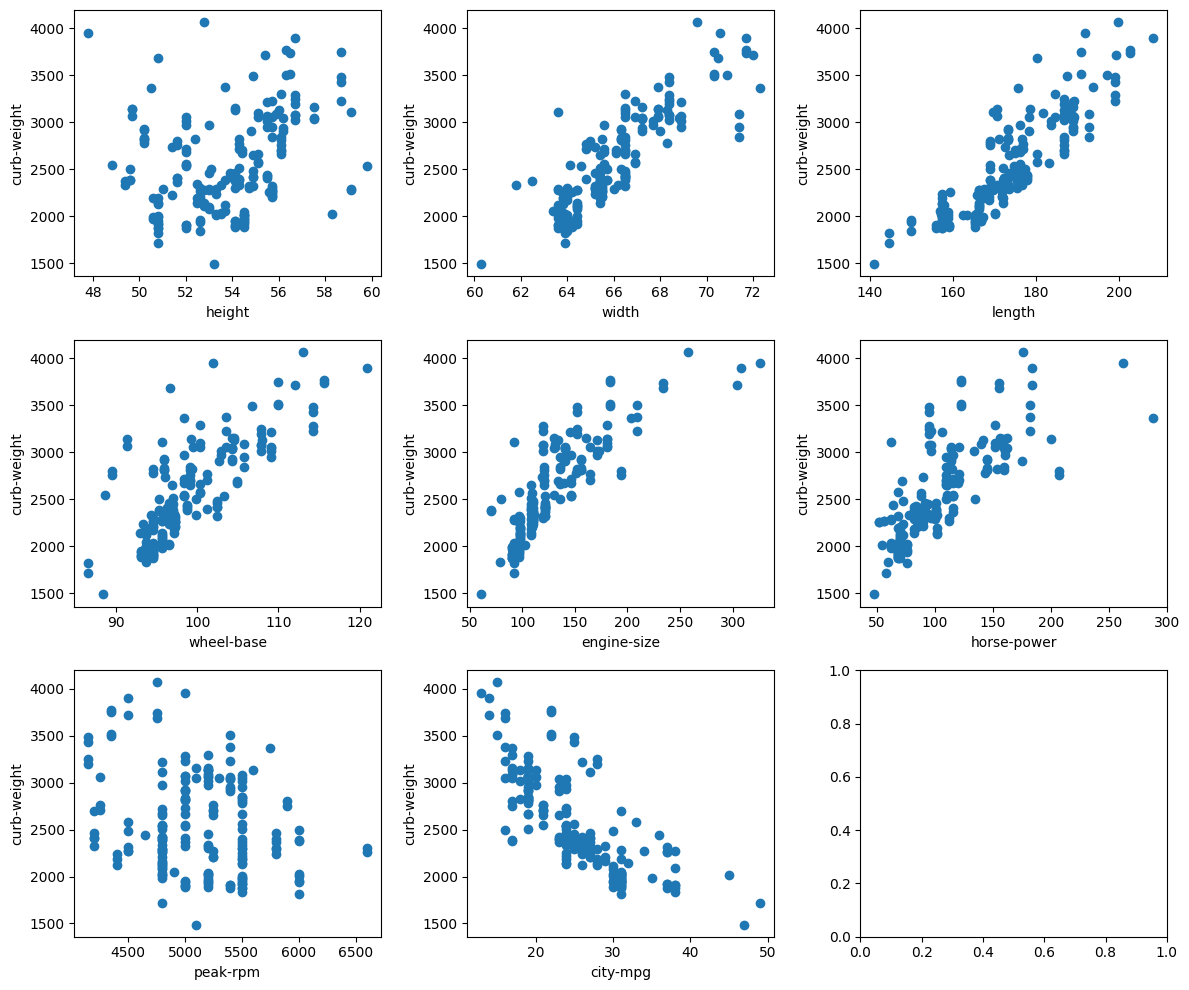

In [148]:
# Draw scatter plots of independent and dependent variables
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(['height', 'width', 'length', 'wheel-base', 'engine-size', 'horse-power', 'peak-rpm', 'city-mpg']):
    axes[i].scatter(df[col], df['curb-weight'])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('curb-weight')

plt.tight_layout()
plt.show()

From the graph, we can see that the length width engine size is roughly linearly correlated with the curve weight. The wheel base horse power city mpg shows a linear relationship, while the height peak rpm shows almost no linear relationship

Below, we use a random forest model to calculate the importance of each variable

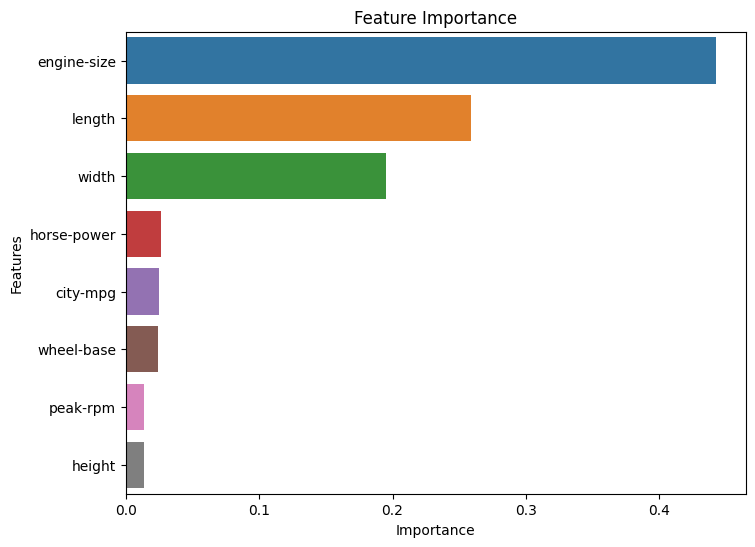

In [149]:
# Calculate feature importance using a random forest model
from sklearn.ensemble import RandomForestRegressor#Import a library of random forest models

X = df[['height', 'width', 'length', 'wheel-base', 'engine-size', 'horse-power', 'peak-rpm', 'city-mpg']]
y = df['curb-weight']

rf = RandomForestRegressor(random_state=42)#Instantiating a model using random seeds
rf.fit(X, y)#fitted model

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
# Draw a histogram of feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, orient='h')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

From the figure, we can see that length width engine-size is more important in wheel-base horse-power city-mpg, followed by height peak rpm, where engine size is the most important attribute and height is the least important attribute

In [150]:
#Separate the response variable from other variables
X=df.copy()
Y=X['curb-weight']
X.drop('curb-weight', axis=1, inplace=True)

In [151]:
#check
X.head()

,wheel-base,length,width,height,engine-size,horse-power,peak-rpm,city-mpg
0,88.6,168.8,64.1,48.8,130,111,5000,21
2,94.5,171.2,65.5,52.4,152,154,5000,19
3,99.8,176.6,66.2,54.3,109,102,5500,24
4,99.4,176.6,66.4,54.3,136,115,5500,18
5,99.8,177.3,66.3,53.1,136,110,5500,19


In [152]:
#check
Y.head()

0    2548
2    2823
3    2337
4    2824
5    2507
Name: curb-weight, dtype: int64

Now that we have prepared the book set, let's divide the dataset into training and testing sets and use a linear regression model for N-fold cross validation

In [153]:
from sklearn.model_selection import train_test_split#Import partition function
from sklearn.linear_model import LinearRegression#Import linear regression model
from sklearn.model_selection import cross_val_score#Import Evaluation Function
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)#Divide the dataset into training and testing sets

In order to compare the impact of using variables of different importance on linear regression models, we chose to create three datasets, which were composed of the most important three variables, the most important three plus the more important three variables, and all variables. In order to compare the impact of different folds on cross validation, we will conduct experiments on three datasets.

In [155]:
three_train = X_train[['engine-size','length', 'width']].copy()#Copy, but as long as you need to use the first three important variables of the column

six_train = X_train[['engine-size','length', 'width','wheel-base','horse-power','city-mpg']].copy()#Copy, but as long as the first six important variables of the required columns are used

eight_train = X_train[['engine-size','length', 'width','wheel-base','horse-power','city-mpg','height','peak-rpm']].copy()#Copy all variables

model = LinearRegression()#模型实例化
scores_three_5 = cross_val_score(model, three_train, y_train, cv=5)#Pass the constructed linear regression model into the specified training set and cross validation strategy with cv=5, which means using a 5-fold cross test
print("three attribute cv=5 train R^2:",np.mean(scores_three_5))#计算平均R2


scores_three_10 = cross_val_score(model, three_train, y_train, cv=10)#Pass the constructed linear regression model into the specified training set and cross validation strategy with cv=10, indicating a 10-fold cross test
print("three attribute cv=10 train R^2:",np.mean(scores_three_10))#Calculate average R2


scores_six_5 = cross_val_score(model, six_train, y_train, cv=5)#Pass the constructed linear regression model into the specified training set and cross validation strategy with cv=5, which means using a 5-fold cross test
print("six attribute cv=5 train R^2:",np.mean(scores_six_5))#Calculate average R2


scores_six_10 = cross_val_score(model, six_train, y_train, cv=10)#Pass the constructed linear regression model into the specified training set and cross validation strategy with cv=10, indicating a 10-fold cross test
print("six attribute cv=10 train R^2:",np.mean(scores_six_10))#Calculate average R2


scores_eight_5 = cross_val_score(model, eight_train, y_train, cv=5)#Pass the constructed linear regression model into the specified training set and cross validation strategy with cv=5, which means using a 5-fold cross test
print("eight attribute cv=5 train R^2:",np.mean(scores_eight_5))#Calculate average R2


scores_eight_10 = cross_val_score(model, eight_train, y_train, cv=10)#Pass the constructed linear regression model into the specified training set and cross validation strategy with cv=10, indicating a 10-fold cross test
print("eight attribute cv=10 train R^2:",np.mean(scores_eight_10))#Calculate average R2


three attribute cv=5 train R^2: 0.8738915624592959
three attribute cv=10 train R^2: 0.849063983222953
six attribute cv=5 train R^2: 0.8867981748046109
six attribute cv=10 train R^2: 0.8702277248061753
eight attribute cv=5 train R^2: 0.8860869516564428
eight attribute cv=10 train R^2: 0.8602110709217783


In addition to linear regression models, we believe that other regression models should also be used for analysis

In [156]:
#Using Ridge Regression
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.5)#岭回归
scores_three_5 = cross_val_score(model, three_train, y_train, cv=5)#将构建的线性回归模型传入 指定训练集和交叉验证的策略 cv=5表示采用5折交叉检验
scores_six_5 = cross_val_score(model, six_train, y_train, cv=5)#将构建的线性回归模型传入 指定训练集和交叉验证的策略 cv=5表示采用五折交叉检验
scores_eight_5 = cross_val_score(model, eight_train, y_train, cv=5)#将构建的线性回归模型传入 指定训练集和交叉验证的策略 cv=5表示采用5折交叉检验
print(np.mean(scores_three_5))
print(np.mean(scores_six_5))
print(np.mean(scores_eight_5))


0.8739181312890107
0.8868120768520997
0.8861253927448509


In [157]:
#Using Lasso Regression
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)#Lasso回归
scores_three_5 = cross_val_score(model, three_train, y_train, cv=5)#将构建的线性回归模型传入 指定训练集和交叉验证的策略 cv=5表示采用5折交叉检验
scores_six_5 = cross_val_score(model, six_train, y_train, cv=5)#将构建的线性回归模型传入 指定训练集和交叉验证的策略 cv=5表示采用五折交叉检验
scores_eight_5 = cross_val_score(model, eight_train, y_train, cv=5)#将构建的线性回归模型传入 指定训练集和交叉验证的策略 cv=5表示采用5折交叉检验
print(np.mean(scores_three_5))
print(np.mean(scores_six_5))
print(np.mean(scores_eight_5))


0.873895429388013
0.8867996361022424
0.8860935598876729


**Conclusions**
Based on our previous analysis of the dataset, we divided attributes into three categories: more relevant variables, related variables, and less relevant variables. We used three schemes in sequence: more relevant variables, more relevant variables+related variables, and related variables+related variables+less relevant variables to fit the regression model and calculate R2. In the end, we concluded that fitting with only relatively relevant variables can achieve the same results as fitting with all variables. The model using all variables is the best, but we believe that this may be due to the small size of the dataset. If fitting on a larger dataset and introducing low correlation variables into the model, it may reduce the effectiveness of the model. We also used Ridge regression and Lasso regression for testing, and the experimental results are similar to those of linear regression.
